# <font color = 'green'> Text cleaning and preprocessing.
Since *cleaned_objective_strategy* has been cleaned in section 1, we will focus on lemmatization and tokenization in this section. </font>

## <font color = 'green'> Lemmatization. </font>


In [34]:
from installdatabase import *
import os
import pickle

path = r'C:\Users\zhaoz\Desktop\finalproject_3035875428_3035876678\data'

In [35]:
strategy_descriptions_esg_related = clickhouse_query('''
select * from common_goods.fund_objectives_strategy_with_labels
where esg_labels != 'Non-ESG'
''')
strategy_descriptions_esg_related.head()

Elapsed time: 0 days 00:00:00.002017 seconds


,adsh,cik_expanded,name,period_end_date,year,objective,strategy,cleaned_objective_strategy,esg_labels
0,0000100334-17-000063,100334,"AMERICAN CENTURY MUTUAL FUNDS, INC.",20170301,2017,The fund seeks long-term capital growth.,The portfolio managers look for stocks of comp...,fund seeks long term capital growth portfolio ...,Corporate Governance
1,0000100334-17-000063,100334,"AMERICAN CENTURY MUTUAL FUNDS, INC.",20170301,2017,The fund seeks long-term capital growth.,"Under normal market conditions, the fund will ...",fund seeks long term capital growth normal mar...,Corporate Governance
2,0000100334-17-000063,100334,"AMERICAN CENTURY MUTUAL FUNDS, INC.",20170301,2017,The fund seeks long-term capital growth.,The fund will generally invest in larger-sized...,fund seeks long term capital growth fund gener...,Corporate Governance
3,0001162044-17-000431,1003839,MATTHEW 25 FUND,20170501,2017,"Matthew 25 Fund (""""the Fund"""") seeks long-term...",The Fund blends Growth and Value Investing in ...,fund seeks long term capital appreciation fund...,Corporate Governance
4,0000932471-17-003517,1004655,VANGUARD WHITEHALL FUNDS,20170223,2017,The Fund seeks to track the performance of a b...,The Fund employs an indexing investment approa...,fund seeks track performance benchmark index m...,Corporate Governance


In [36]:
#%pip install Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#%pip install spacy
import spacy
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm", disable=['ner'])

def run_NLP(content):

    def sent_to_words(text):
        yield(gensim.utils.simple_preprocess(text))

    # Define functions for bigrams, trigrams and lemmatization

    def make_bigrams(texts):
        return [bigram_mod[doc] for doc in texts]

    def make_trigrams(texts):
        return [trigram_mod[bigram_mod[doc]] for doc in texts]

    def lemmatization(texts, allowed_postags=['NOUN', 'ADJ']):
        """https://spacy.io/api/annotation"""
        texts_out = []
        for sent in texts:
            doc = nlp(' '.join(sent))
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        return texts_out

    data_words = list(sent_to_words(content))

    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words)

    # Do lemmatization keeping only noun, adj, vb, adv
    lemma = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ'])
    
    return lemma

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [37]:
from tqdm import tqdm, trange

lemmas = []

for s in strategy_descriptions_esg_related['cleaned_objective_strategy']:
    lemma = run_NLP(s)[0]
    lemmas.append(lemma)

In [38]:
#save lemmas as pickle file
with open(path + r'\lemmas.pickle', 'wb') as f:
    pickle.dump(lemmas, f)

## <font color = 'green'> Drop customize stopwords. 
Although we have removed common english stopwords from raw text in section 1, there are certain words out of *nltk stopwords* we'd like to drop before analysis. </font>

In [39]:
import os
import pickle

path = r'C:\Users\zhaoz\Desktop\finalproject_3035875428_3035876678\data'

#read lemmas from pickle file
with open(path + r'\lemmas.pickle', 'rb') as f:
    lemmas = pickle.load(f)

DescribeResult(nobs=3064, minmax=(1, 12771), mean=69.09007832898172, variance=158767.35068180907, skewness=18.331712692384542, kurtosis=450.5682453994893)


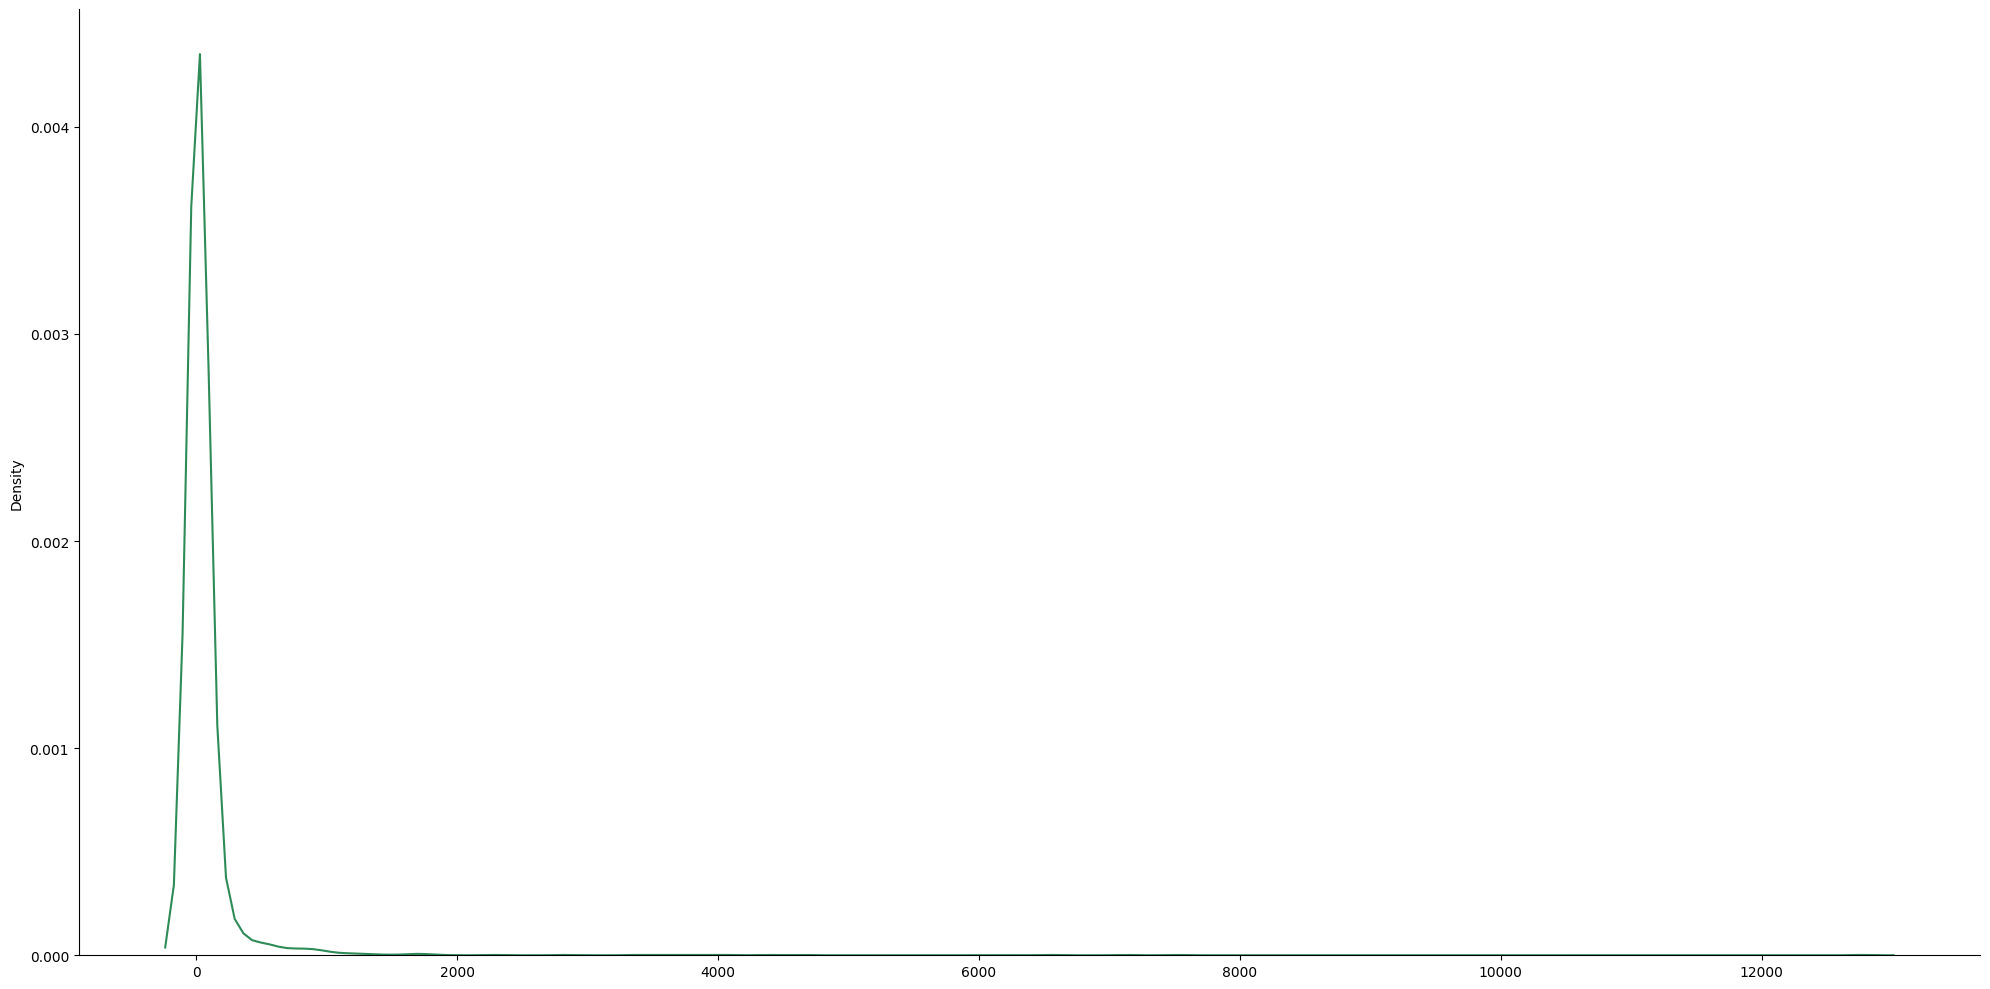

In [40]:
# aggregate all text into one large string to run counter on term frequency
large_string = ' '.join(word for l in lemmas for word in l)

#count the apparence frequency of all the noun 
from collections import Counter        

words_freq = Counter(large_string.split())

#%pip install scipy
from scipy import stats
import numpy as np

freqs = np.array(list(words_freq.values()))

import seaborn as sns
sns.displot(freqs, kind="kde", color='seagreen', height=10, aspect=2)

print(stats.describe(freqs, axis=0, ddof=1, bias=True, nan_policy='propagate'))

We can see that corpus distribution is extremely left-skewed. We will drop words with too many or too few occurrence from the whole corpus since these words could be not conducive for us to featuring paragraphs.

In [41]:
full_words = list(words_freq.keys())

#quantiles
min_count = 5
max_count = 500

def remove_key(d):
    for key in list(d.keys()):
        if (key.isalpha() == False) or (len(key)<2):
            d.pop(key)
        if (d[key] > max_count) or (d[key] < min_count):
            del d[key]

words_freq_copy = words_freq.copy()

remove_key(words_freq_copy)

drop_words = list(set(full_words)-set(list(words_freq_copy.keys())))

print('number of drop words: ', len(drop_words))
print('number of remaining words: ', len(words_freq_copy))

number of drop words:  1518
number of remaining words:  1546


In [42]:
#save drop_words as pickle file
with open(path + r'\drop_words.pickle', 'wb') as f2:
    pickle.dump(drop_words, f2)

## <font color = 'green'> Corpus wide term frequencies </font>

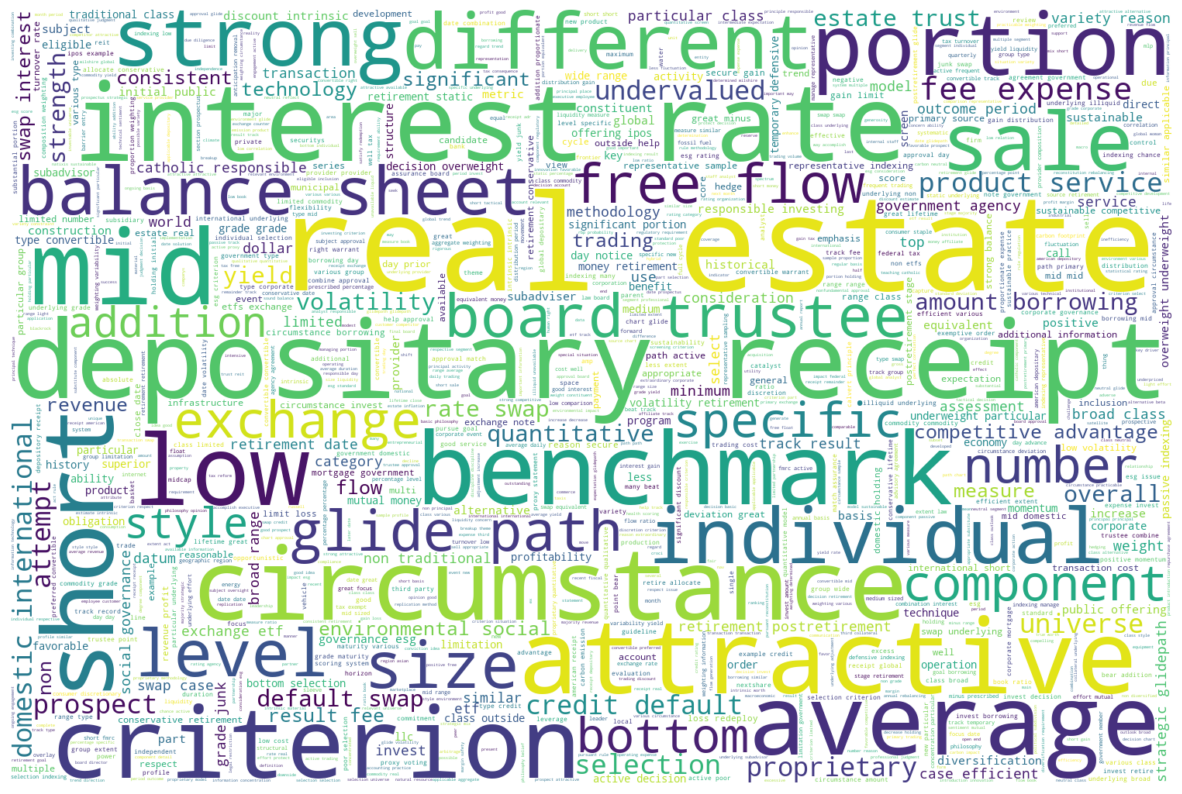

In [51]:
#%pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

# use 3rd party lib to compute term freq., apply stop words
word_cloud = WordCloud(
    stopwords=drop_words,
    background_color="white",
    max_words=1000, 
    width=1500, 
    height=1000,
    contour_width=3, 
    contour_color='seagreen'
)

# display our wordcloud across all records
plt.figure(figsize=(15,15))
word_cloud.generate(large_string)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

0             class
1               mid
2         criterion
3             range
4      circumstance
5        underlying
6               low
7              rate
8         selection
9             short
10         exchange
11             swap
12       particular
13             date
14       attractive
15              esg
16       retirement
17         interest
18        borrowing
19             flow
20           invest
21              non
22          portion
23             type
24          receipt
25              day
26       government
27          trading
28          various
29             real
30     quantitative
31              tax
32         decision
33          similar
34      convertible
35        corporate
36          average
37        intrinsic
38            track
39           global
40        principal
41          service
42            grade
43         addition
44    international
45       individual
46           strong
47            broad
48          product
49          revenue


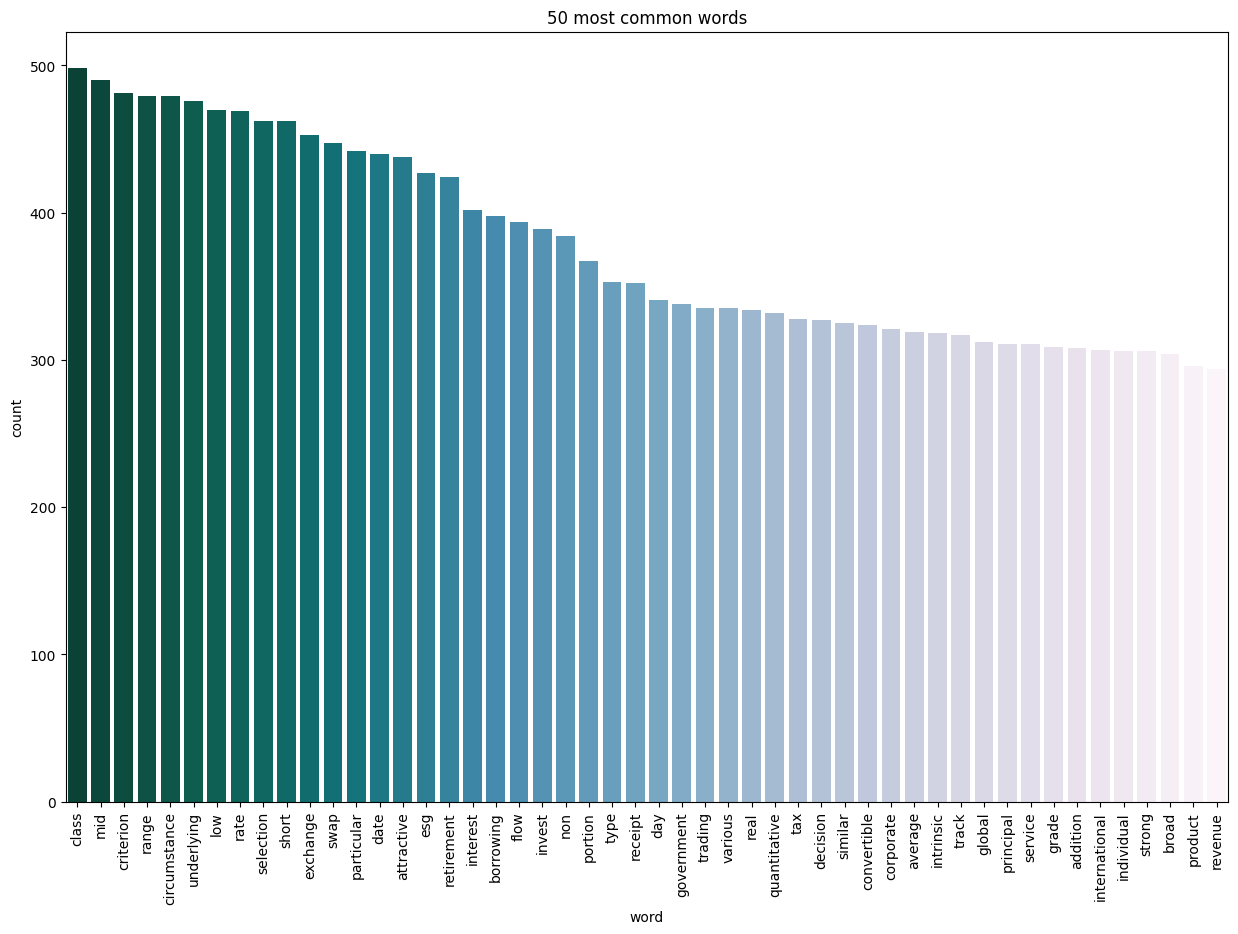

In [52]:
#%pip install seaborn
import seaborn as sns
import pandas as pd

#remove drop words from large string and count the word frequency again
large_string = ' '.join(word for l in lemmas for word in l if word not in drop_words)

words_freq = Counter(large_string.split())

most_common_words = words_freq.most_common(50)
most_common_words = pd.DataFrame(most_common_words, columns=['word', 'count'])

print(most_common_words['word'])

# Plot top 50 ngrams
plt.figure(figsize=(15, 10))
plt.subplot(title='50 most common words')
sns.barplot(x=most_common_words['word'], y=most_common_words['count'], palette='PuBuGn_r')
plt.xticks(rotation=90)
plt.show()

# <font color = 'green'> Topic Modeling</font>

## <font color = 'green'> TFIDF - Bigram Analysis </font>

In [53]:
#%pip install scikit-learn
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np

string_lemmas = []
for l in lemmas:
    string_lemma = ' '.join(word for word in l)
    string_lemmas.append(string_lemma)
 
# Run bi-gram TF-IDF frequencies
bigram_tf_idf_vectorizer = TfidfVectorizer(stop_words = drop_words, ngram_range=(1,2), min_df=10, use_idf=True)
bigram_tf_idf = bigram_tf_idf_vectorizer.fit_transform(string_lemmas)

In [54]:
with open(path + r'\b_tfidf.pickle', 'wb') as f3:
    pickle.dump(bigram_tf_idf, f3)

## <font color = 'green'> Principal Component Analysis (PCA) </font>

In [55]:
import os
import pickle

path = r'C:\Users\zhaoz\Desktop\finalproject_3035875428_3035876678\data'

#read bigram_tf_idf from pickle file
with open(path + r'\b_tfidf.pickle', 'rb') as f3:
    bigram_tf_idf = pickle.load(f3)

In [56]:
import pandas as pd

idf = pd.DataFrame(bigram_tf_idf.todense(), columns = bigram_tf_idf_vectorizer.get_feature_names_out())

idf['adsh'] = strategy_descriptions_esg_related['adsh']
idf.head()

,ability,ability addition,ability critical,ability liquidity,able,absolute,acceptable,access,accomplish,accomplish executive,...,workplace,world,worth,worth individual,yield,yield junk,yield liquidity,yield rate,yield yield,adsh
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0000100334-17-000063
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0000100334-17-000063
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.104747,0.0,0.0,0.0,0.0,0000100334-17-000063
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0001162044-17-000431
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.395790,0.0,0.0,0.0,0.0,0000932471-17-003517


In [57]:
#save idf as pickle file
with open(path + r'\idf.pickle', 'wb') as f4:
    pickle.dump(idf, f4)

#save idf as parquet file
idf.to_parquet(path + r'\idf.parquet')

100%|██████████| 7/7 [00:09<00:00,  1.30s/it]


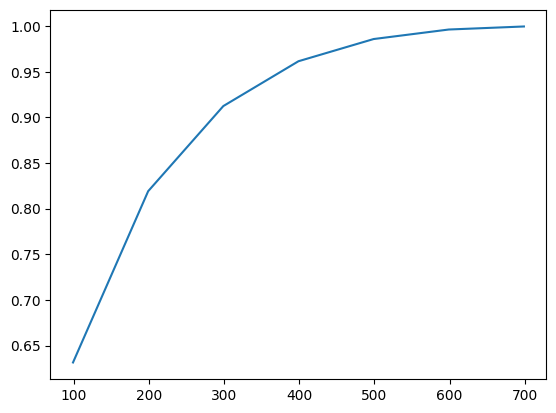

[0.63151303843818,
 0.8191466676254127,
 0.912380330768843,
 0.9614965779910016,
 0.9857995596269442,
 0.9962354482514654,
 0.9995618244314793]

In [58]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
#https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA.set_params
from tqdm import tqdm

score_all=[]

no_of_components = range(99, 700, 100)

df = idf.iloc[:,idf.columns!= 'adsh']

for i in tqdm(no_of_components):
    pca = PCA(n_components=i)
    reduced_data = pca.fit_transform(df) 
    score= pca.explained_variance_ratio_
    score_all.append(score.sum())

plt.plot(no_of_components,score_all)
plt.show()
score_all

In [59]:
pca = PCA(n_components=399)
reduced_bigram_tf_idf = pca.fit_transform(df)
trans_matric = pca.components_
index = [col for col in df.columns]
pca_array = np.dot(idf[np.unique(index)].to_numpy(),trans_matric.T)

## <font color = 'green'> KMeans Clustering </font>

c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


2 cluster has calinski_harabaz score：23.371022


c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


12 cluster has calinski_harabaz score：14.276057


c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


22 cluster has calinski_harabaz score：12.763180


c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


32 cluster has calinski_harabaz score：11.452800


c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


42 cluster has calinski_harabaz score：10.505894


c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


52 cluster has calinski_harabaz score：9.719041


c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


62 cluster has calinski_harabaz score：9.361353


c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


72 cluster has calinski_harabaz score：8.992535


c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


82 cluster has calinski_harabaz score：8.633809


c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


92 cluster has calinski_harabaz score：8.313163


c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


102 cluster has calinski_harabaz score：8.184159


c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


112 cluster has calinski_harabaz score：8.040704


c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


122 cluster has calinski_harabaz score：7.848418


c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


132 cluster has calinski_harabaz score：7.796197


c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


142 cluster has calinski_harabaz score：7.709988


c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


152 cluster has calinski_harabaz score：7.678788


c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


162 cluster has calinski_harabaz score：7.766503


c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


172 cluster has calinski_harabaz score：7.684538


c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


182 cluster has calinski_harabaz score：7.631099


c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


192 cluster has calinski_harabaz score：7.634183


c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


202 cluster has calinski_harabaz score：7.755493


c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


212 cluster has calinski_harabaz score：7.677245


c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


222 cluster has calinski_harabaz score：7.612030


c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


232 cluster has calinski_harabaz score：7.604003


c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


242 cluster has calinski_harabaz score：7.664345


c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


252 cluster has calinski_harabaz score：7.707350


c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


262 cluster has calinski_harabaz score：7.790438


c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


272 cluster has calinski_harabaz score：7.813273


c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


282 cluster has calinski_harabaz score：8.009535


c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


292 cluster has calinski_harabaz score：7.979135


c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


302 cluster has calinski_harabaz score：8.117921


c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


312 cluster has calinski_harabaz score：8.197858


c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


322 cluster has calinski_harabaz score：8.284320


c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


332 cluster has calinski_harabaz score：8.569114


c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


342 cluster has calinski_harabaz score：8.781430


c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


352 cluster has calinski_harabaz score：9.044626


c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


362 cluster has calinski_harabaz score：9.191364


c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


372 cluster has calinski_harabaz score：9.530789


c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


382 cluster has calinski_harabaz score：9.898109


c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


392 cluster has calinski_harabaz score：10.311635


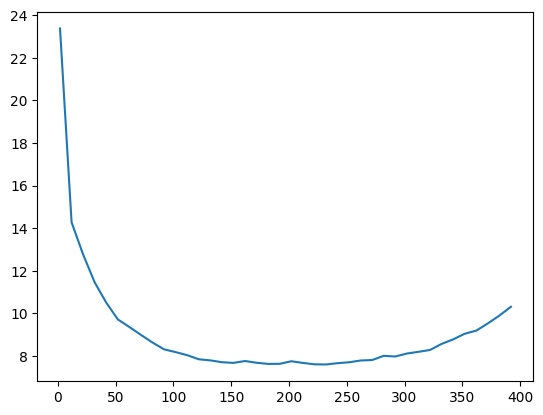

In [67]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score

score_all=[]

list_1 = range(2,400,10)

for i in list_1:
    kmeans = KMeans(n_clusters=i,random_state=42).fit(pca_array)
    score=calinski_harabasz_score(pca_array,kmeans.labels_)
    score_all.append(score)
    print('%d cluster has calinski_harabaz score：%f'%(i,score))
plt.plot(list_1,score_all)
plt.show()

c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

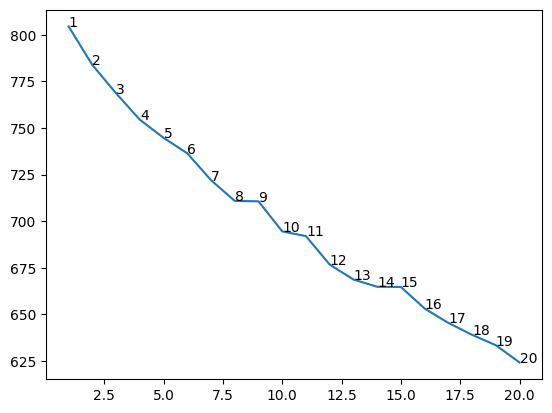

In [78]:
# sse 
import numpy as np
import sklearn
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# test what k is suitable
k = np.arange(1,21,1)
jarr = []
for i in k:
    model = KMeans(n_clusters=i)
    model.fit(pca_array)
    jarr.append(model.inertia_)
    plt.annotate(str(i),(i,model.inertia_))
plt.plot(k,jarr)
plt.show()

In [89]:
# K-means 
from sklearn.metrics import calinski_harabasz_score
kmeans = KMeans(n_clusters = 8,random_state = 42).fit(pca_array)
cluster_num = kmeans.predict(pca_array)

c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [93]:
r1=pd.Series(kmeans.labels_).value_counts()
r1

3    461
5    173
4     89
1     44
0     40
6     33
2     25
7     23
Name: count, dtype: int64

In [120]:
labels = kmeans.labels_
label = pd.DataFrame(labels,columns=['kmeans_label'])
result = pd.concat([strategy_descriptions_esg_related, label],axis=1)

result.head()

,adsh,cik_expanded,name,period_end_date,year,objective,strategy,cleaned_objective_strategy,esg_labels,kmeans_label
0,0000100334-17-000063,100334,"AMERICAN CENTURY MUTUAL FUNDS, INC.",20170301,2017,The fund seeks long-term capital growth.,The portfolio managers look for stocks of comp...,fund seeks long term capital growth portfolio ...,Corporate Governance,3
1,0000100334-17-000063,100334,"AMERICAN CENTURY MUTUAL FUNDS, INC.",20170301,2017,The fund seeks long-term capital growth.,"Under normal market conditions, the fund will ...",fund seeks long term capital growth normal mar...,Corporate Governance,3
2,0000100334-17-000063,100334,"AMERICAN CENTURY MUTUAL FUNDS, INC.",20170301,2017,The fund seeks long-term capital growth.,The fund will generally invest in larger-sized...,fund seeks long term capital growth fund gener...,Corporate Governance,1
3,0001162044-17-000431,1003839,MATTHEW 25 FUND,20170501,2017,"Matthew 25 Fund (""""the Fund"""") seeks long-term...",The Fund blends Growth and Value Investing in ...,fund seeks long term capital appreciation fund...,Corporate Governance,3
4,0000932471-17-003517,1004655,VANGUARD WHITEHALL FUNDS,20170223,2017,The Fund seeks to track the performance of a b...,The Fund employs an indexing investment approa...,fund seeks track performance benchmark index m...,Corporate Governance,4


In [121]:
result.to_parquet(path + r'\common_goods.pca_kmeans.parquet')

In [122]:
from installdatabase import *

clickhouse_query('drop table if exists common_goods.pca_kmeans')


clickhouse_query('''
create table if not exists common_goods.pca_kmeans
Engine = MergeTree()
ORDER BY tuple() AS
SELECT *
FROM file('data/common_goods.pca_kmeans.parquet', Parquet)
''')


Elapsed time: 0 days 00:00:00 seconds
Elapsed time: 0 days 00:00:00 seconds


""


In [140]:
clickhouse_query('select distinct esg_labels from common_goods.pca_kmeans')

Elapsed time: 0 days 00:00:00 seconds


,esg_labels
0,Corporate Governance
1,Community Relations
2,Climate Change
3,Natural Capital
4,Human Capital


In [173]:
clickhouse_query('drop view if exists common_goods.two_classes')

clickhouse_query('''
create view if not exists common_goods.two_classes as

select distinct kmeans_label, esg_label_num, count(joint_label) as count
from (select kmeans_label, esg_label_num, kmeans_label*10+esg_label_num as joint_label
            from (select kmeans_label, (case
                                        when esg_labels = 'Corporate Governance' then 0
                                        when esg_labels = 'Community Relations' then 1
                                        when esg_labels = 'Climate Change' then 2
                                        when esg_labels = 'Natural Capital' then 3
                                        else 4
                                        end) as esg_label_num
                from common_goods.pca_kmeans))
group by kmeans_label, esg_label_num, joint_label
order by kmeans_label, esg_label_num, joint_label
''')

two_classes = clickhouse_query('select * from common_goods.two_classes')
two_classes

Elapsed time: 0 days 00:00:00 seconds
Elapsed time: 0 days 00:00:00 seconds
Elapsed time: 0 days 00:00:00 seconds


,kmeans_label,esg_label_num,count
0,0,0,40
1,1,0,33
2,1,2,11
3,2,0,25
4,3,0,438
5,3,1,13
6,3,2,6
7,3,4,4
8,4,0,81
9,4,1,1


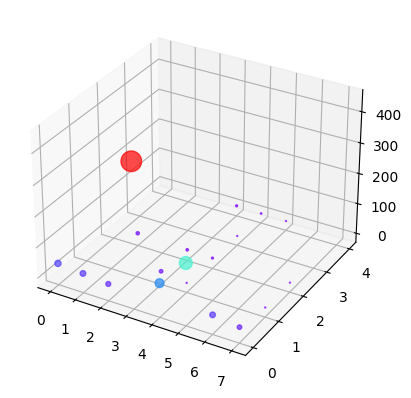

In [190]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = plt.axes(projection='3d')

X = two_classes['kmeans_label']
Y = two_classes['esg_label_num']
Z = two_classes['count']

ax.scatter(X,Y,Z, cmap='rainbow', c = Z, s = Z/2, alpha=0.7)

plt.show()

## <font color = 'green'> Latent Dirichlet Allocation (LDA) </font>
We will use LDA model to get topics and features.</br>

*Ref:* https://radimrehurek.com/gensim/models/ldamodel.html

In [ ]:
import os
import pickle
import pandas as pd
import numpy as np

path = r'C:\Users\zhaoz\Desktop\finalproject_3035875428_3035876678\data'

In [ ]:
lemmas = pickle.load(open(path + r'\lemmas.pickle', 'rb'))
drop_words = pickle.load(open(path + r'\drop_words.pickle', 'rb'))

In [ ]:
#remove drop words from lemma
clean_lemmas = []
for l in lemmas:
    clean_lemma = [word for word in l if word not in drop_words]
    clean_lemmas.append(clean_lemma)

In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Create Dictionary
id2word = corpora.Dictionary(lemmas)

# Term Document Frequency
corpus = [id2word.doc2bow(lemma) for lemma in lemmas]

In [ ]:
from tqdm import tqdm, trange

results = []
optimal_score = 0
optimal_model = None

for num_of_topics in trange(1,21,1):
    
    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics = num_of_topics,
                                            random_state=10,
                                            update_every=1,
                                            chunksize=10,
                                            alpha='auto',
                                            eta='auto',
                                            per_word_topics=True) 
    
    result = {}
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=lemmas, dictionary=id2word, coherence='c_v')
    
    if optimal_score < coherence_model_lda.get_coherence():
        optimal_score = coherence_model_lda.get_coherence()
        optimal_model = lda_model

    result['num_of_topics'] = num_of_topics
    result['perplexity'] = lda_model.log_perplexity(corpus)
    result['coherence_score'] = coherence_model_lda.get_coherence()
    
    results.append(result)


results = pd.DataFrame(results)  
results.set_index('num_of_topics', inplace=True)
results

100%|██████████| 20/20 [06:06<00:00, 18.31s/it]


,perplexity,coherence_score
num_of_topics,,
1,-5.936005,0.338909
2,-5.872867,0.443636
3,-5.865132,0.426526
4,-5.875111,0.425284
5,-5.925447,0.406297
6,-5.951773,0.404095
7,-5.964920,0.395641
8,-5.995399,0.384423
9,-6.049899,0.432423


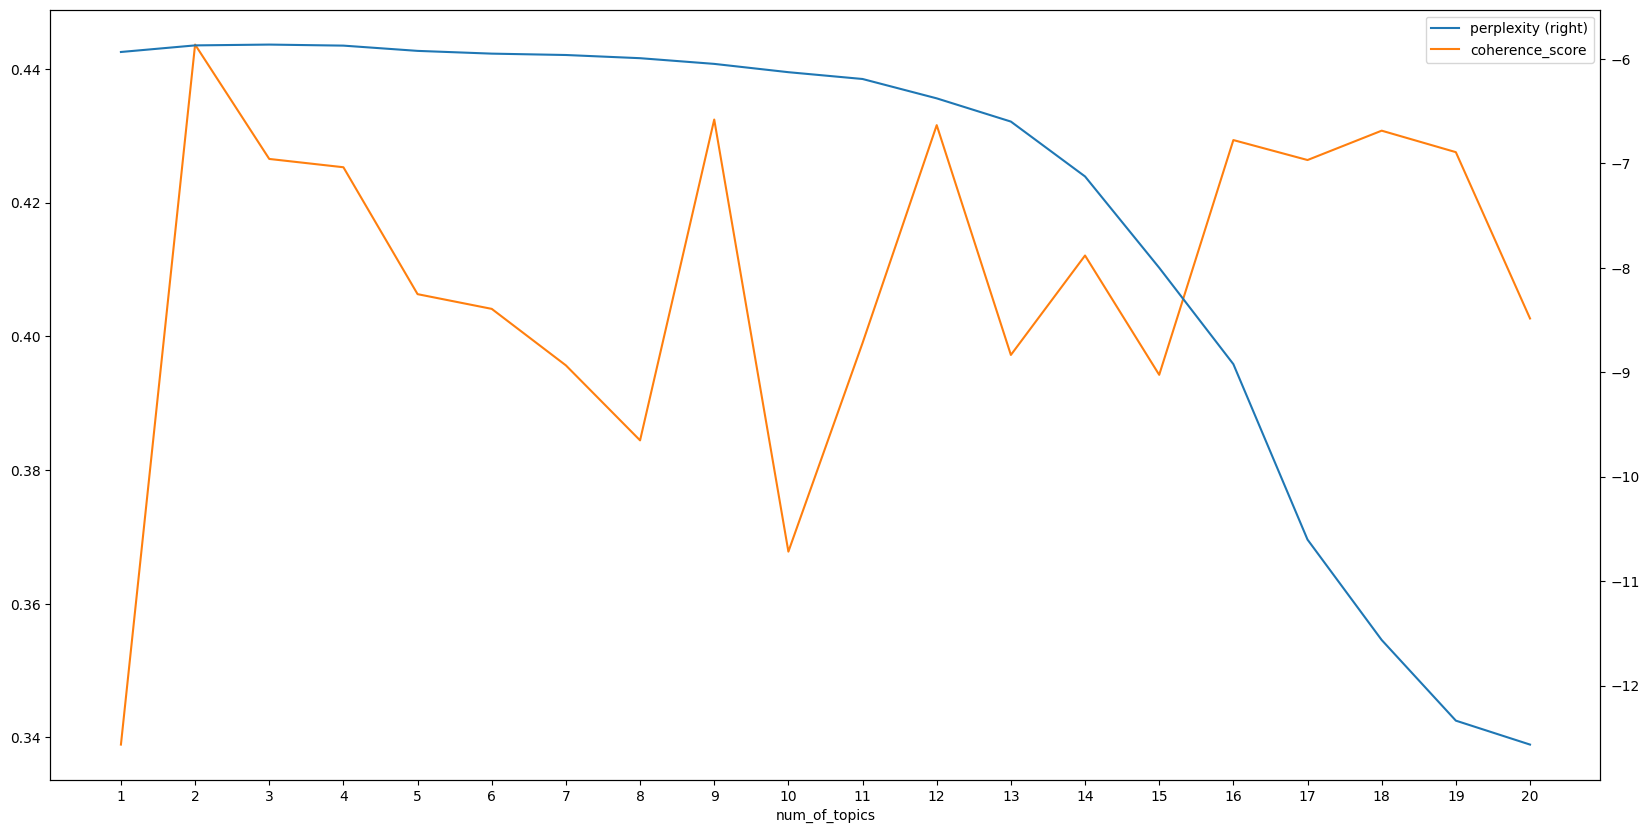

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

results.plot(secondary_y='perplexity', figsize=(20, 10))
new_ticks = np.linspace(1, 20, 20)
plt.xticks(new_ticks)
plt.show()

We can use a visualization tool *pyLDAvis* to help us understand the topics better. </br>
    
*Ref:*</br>
https://pypi.org/project/pyLDAvis/</br>
https://blog.csdn.net/qq_39496504/article/details/107125284</br>

In [ ]:
#%pip install pyLDAvis

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(optimal_model, corpus, id2word)
pyLDAvis.save_html(vis, path + os.sep + '../img/lda.html')
pyLDAvis.display(vis)